<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a><br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Fundamental Factors](Introduction.ipynb) › Lesson 5: Exploratory Data Analysis
***

# Exploratory Data Analysis

Pipeline output can be fed into a Zipline strategy or analyzed with Alphalens. However, a useful first step in most cases is to explore the data to get a basic sense of the data's distribution and characteristics. This can often highlight ways that you must massage the data or tweak your computations to achieve the desired results. This process is referred to as Exploratory Data Analysis (EDA).


## Exploring the Profitability Factor

In an earlier lesson, we defined a factor for operating margin, defined as operating income divided by revenue. Operating margin is a measure of profitability. If a company has an operating margin of 10% (0.1), this means that for every dollar of revenue, the company earns 10 cents in operating income.

> Although these lessons will refer to operating margin as the profitability factor, note that operating margin is a different profitability measure than the [Fama-French profitability factor](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2287202). The main differences are that the Fama-French version subtracts interest from revenue while operating margin does not, and the Fama-French version divides the numerator by book equity while operating margin divides by revenue. The choice of operating margin in these lessons is pedagogical and does not constitute an endorsement of one formula over the other. The Fama-French profitability factor can be computed with the following Sharadar fields: `(REVENUE - COR - INTEXP - SGNA) / EQUITY`


Suppose we wanted to use Alphalens to assess the suitability of including operating margin in a long-short or long-only strategy. What might our exploratory data analysis look like? 

Let's begin by creating a pipeline with this factor, importing our universe filters from lesson 2: 

In [1]:
from zipline.pipeline import Pipeline, sharadar
from codeload.fundamental_factors.universe import CommonStocks, BaseUniverse

fundamentals = sharadar.Fundamentals.slice('ART')

operating_margin = fundamentals.OPINC.latest / fundamentals.REVENUE.latest 

pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
    },
    initial_universe=CommonStocks(),
    screen=BaseUniverse()
)

Then, we run the pipeline with a year of data. A year (or even less) is often sufficient for the purpose of exploratory data analysis, since the purpose is simply to get a basic understanding of the data distribution and characteristics. In contrast, longer date ranges are beneficial when analyzing factor performance with Alphalens or Zipline, in order to see how the factor performs over time.

In [2]:
from zipline.research import run_pipeline

results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')

## Summarizing the data with pandas' `describe()` method

An easy and fail-safe first way to explore the data is using pandas's `describe()` method, which computes summary statistics for each column in the DataFrame. We will visualize the data distribution with a histogram later, but `describe()` is nice because it works for any kind of data and doesn't require us to think in advance about what kind of plot is best suited to the data, a task that can be tricky when we don't yet have a basic understanding of the data distribution.

In [3]:
results.describe()

,operating_margin
count,1.036630e+06
mean,NaN
std,NaN
min,-inf
25%,-2.471616e-01
50%,6.503638e-02
75%,2.044458e-01
max,inf


We immediately notice the `NaN` and `inf` values in the `describe()` output. What's going on here? This is happening because we are dividing operating income by revenue, and revenue can be 0. Dividing by zero causes numpy to compute +/-infinity for max and min, and the `inf` values cause the `NaN` values for mean and std. A quick check of `describe()` has highlighted a problem that we should correct before going any further. 

A simple solution is to use the Factor `where()` method to ignore observations where revenue is 0. The `where()` method takes a Filter (Pipeline's version of a boolean condition) as its first argument, and returns a new Factor with only those values where the Filter is True. A replacement value can be passed as an optional second argument, but if this is omitted, as we do below, the Factor will be masked with `NaN` values where the Filter is False. These `NaN`s will then be ignored in subsequent analyses.

We re-write the operating margin factor to ignore observations with no revenue as follows:

In [4]:
revenue = fundamentals.REVENUE.latest
operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
    },
    initial_universe=CommonStocks(),
    screen=BaseUniverse()
)

Re-running the pipeline and `describe()` method, we see that the `NaN` and `inf` values are gone:

In [5]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.describe()

,operating_margin
count,944237.000000
mean,-40.714307
std,4989.082683
min,-841260.400000
25%,-0.065883
50%,0.081923
75%,0.222380
max,7.001749


What else can we learn from `describe()`? Simplistically, we can think of profit margin as the amount of revenue left over after paying expenses. A company with no revenue left over after expenses would have a profit margin of 0, while a company with no expenses would have a profit margin of 1. But `describe()` reminds us that operating margin is not bounded by 0 and 1. First of all, operating income can be negative, so operating margin can also be negative: a company can spend arbitrarily more than it brings in as revenue. This isn't surprising or unintuitive but it is a useful reminder that our universe currently doesn't just include profitable companies with wider or narrower profit margins but also unprofitable companies that are losing varying amounts of money. Depending on our goals, we may want to include those unprofitable companies in our analysis or exclude them.  

A second revelation of `describe()` is more puzzling: operating margin can be greater than 1. This violates the intuitive understanding of profit margin as the amount of revenue left over after paying expenses. How can there be more than 100% of revenue left over after paying expenses? 

To see what's going on, we should look at some specific examples. We'll re-run the pipeline, but this time we'll screen for stocks with operating margin greater than 1, and we will include in the output all of the relevant columns that form the basis of operating margin, to help us see where the unexpected result is coming from. To know what columns are relevant, you can start by adding `REVENUE` and `OPINC`, which are the basis of operating margin, then clicking on them in JupyterLab and pressing CTRL to view their definitions, which will show you the names of any underlying columns from which they're derived. `REVENUE` comes directly from the income statement, while `OPINC` is derived from `GP` (gross profit) and `OPEX` (operating expenses). `GP`, in turn, depends on `COR` (cost of revenue).

We run a pipeline with these columns and look at a few of the results:

In [6]:
pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin, # operating_margin = OPINC / REVENUE
        'revenue': fundamentals.REVENUE.latest,
        'operating_income': fundamentals.OPINC.latest, # OPINC = GP - OPEX
        'gross_profit': fundamentals.GP.latest, # GP = REVENUE - COR
        'cost_of_revenue': fundamentals.COR.latest,
        'operating_expenses': fundamentals.OPEX.latest
    },
    initial_universe=CommonStocks(),
    screen=BaseUniverse() & (operating_margin > 1)
)

results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.sort_values('operating_margin', ascending=False).drop_duplicates().head()

,,operating_margin,revenue,operating_income,gross_profit,cost_of_revenue,operating_expenses
date,asset,,,,,,
2023-01-03 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),7.001749,10866000.0,76081000.0,8507000.0,2359000.0,-67574000.0
2022-08-29 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),4.515059,16369000.0,73907000.0,8058000.0,8311000.0,-65849000.0
2022-06-03 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),3.936445,16820000.0,66211000.0,3317000.0,13503000.0,-62894000.0
2022-04-01 00:00:00+00:00,Equity(FIBBG000D6DM44 [STRS]),2.962884,28236000.0,83660000.0,4024000.0,24212000.0,-79636000.0
2022-12-19 00:00:00+00:00,Equity(FIBBG004HQHKK0 [AMBC]),1.517751,338000000.0,513000000.0,694000000.0,-356000000.0,181000000.0


In these examples, operating expenses or cost of revenue is negative, which accounts for operating margin being greater than 1. A negative operating expense or cost of revenue is unexpected and may indicate an unusual one-time accounting adjustment made by the company; further investigation (such as viewing the full report on the SEC website) would be required to determine with certainty. Regardless, for the purpose of our profitability analysis, we probably don't want to treat a company with negative operating expenses or negative cost of revenue as though it were extraordinarily profitable. Therefore, we can refine our profitability factor further by excluding these companies.

In [7]:
revenue = fundamentals.REVENUE.latest
operating_margin = fundamentals.OPINC.latest / revenue.where(revenue > 0) 

# exclude companies with negative operating expenses or negative cost of revenue
opex = fundamentals.OPEX.latest
cor = fundamentals.COR.latest
operating_margin = operating_margin.where((opex > 0) & (cor > 0))

pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin,
    },
    initial_universe=CommonStocks(),
    screen=BaseUniverse()
)

Re-running the refined pipeline, the output from `describe()` conforms better to expectations, as the maximum operating margin is now slightly below 1.0:

In [8]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.describe()

,operating_margin
count,777637.000000
mean,-40.002138
std,5480.989899
min,-841260.400000
25%,-0.064361
50%,0.067519
75%,0.165043
max,0.965168



## Visualizing the data distribution

Now that we've refined our factor to exclude unusual cases, let's look at a histogram of operating margin to get a better feel for its distribution. We can use pandas's `plot.hist()` method to do so. However, the plot we get for the data on the first try is not very informative, as all the observations are crammed into a single bin: 

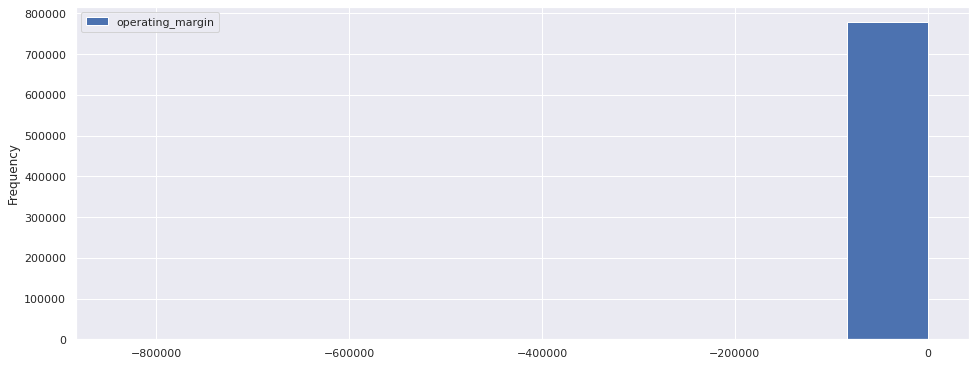

In [9]:
results.plot.hist();

The problem is that negative outliers (companies with extremely negative operating margins) are causing most values to be crammed in a single bin. We can fix this by using the `range` argument to `hist()` to zoom in on the bulk of the distribution. In addition, we'll increase the number of bins to 20, from the default 10.

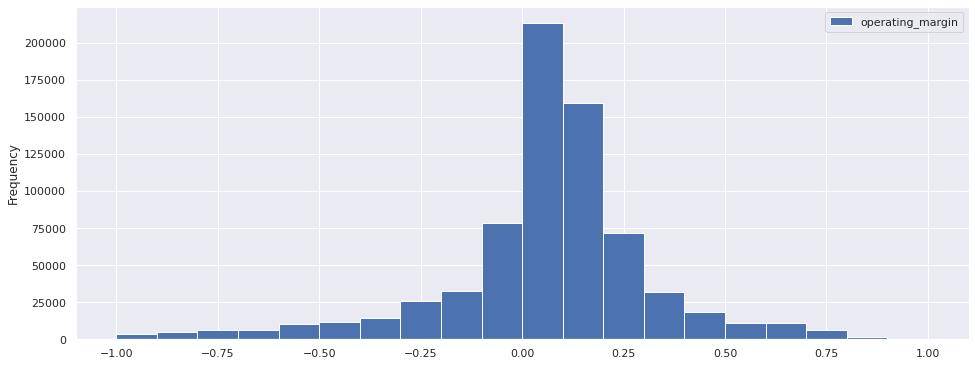

In [10]:
results.plot.hist(bins=20, range=(-1, 1));

## Clipping Outliers

Using `range` to zoom in on the distribution is useful for viewing the histogram, but it doesn't remove the outliers from the pipeline output itself. Before using the pipeline output in Alphalens or Zipline, perhaps it would be a good idea to adjust the pipeline to deal with the outliers. Beyond a certain point, increasingly negative operating margins don't provide useful additional information; it's enough to know that the company is very unprofitable. So, a reasonable solution is to clip the values to -1. This means that any values less than -1 will be replaced with -1. The Factor `clip()` method requires both a lower and upper bound. We'll set the upper bound to 1, knowing that since we already excluded companies with operating margins above 1, the upper bound is redundant. (The lower and upper bound can be set to `-np.inf` and `np.inf`, respectively, to indicate no bound.) 

In [11]:
pipeline = Pipeline(
    columns={
        'operating_margin': operating_margin.clip(min_bound=-1, max_bound=1),
    },
    initial_universe=CommonStocks(),
    screen=BaseUniverse()
)

If we re-run the pipeline, we can now plot the histogram without using `range`. Notice that, unlike the previous histogram which ignored data outside the (-1, 1) range, in this histogram the clipped values cluster at -1. In other words, the previous histogram included a subset of the data, while this histogram includes all the data. 

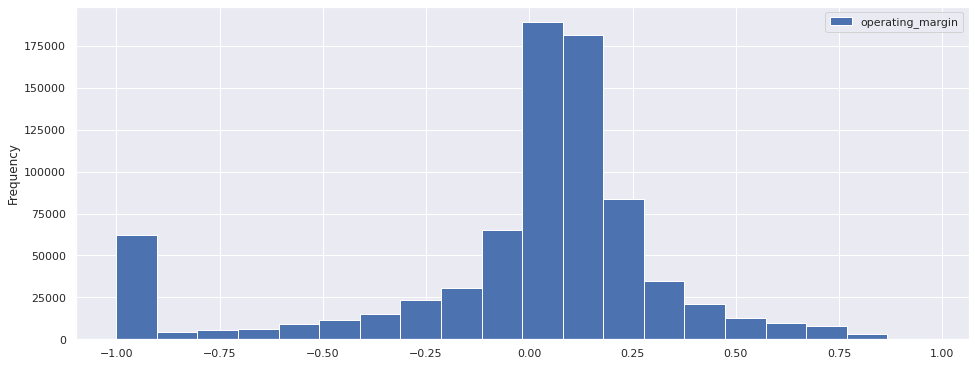

In [12]:
results = run_pipeline(pipeline, '2022-01-01', '2022-12-31')
results.plot.hist(bins=20);

An alternative to using `clip()` would be to use `winsorize()`. The difference is that `winsorize()` trims values above and below a certain percentile in the distribution, while `clip()` trims values above and below specific fixed values. 

***

## *Next Up*

Lesson 6: [Alphalens: Profitability](Lesson06-Profitability.ipynb)